In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import random
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from pycox.models import utils
from pycox.utils import idx_at_times
import pandas as pd
import copy
import pickle
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [4]:
import os, sys
sys.path.append(os.path.abspath('..')) 

from baselines.config import Config, BASELINE_MODEL_FAMILY, TIME_INJECTION_MODEL_FAMILY
from baselines.train_utils import init_trainer, get_target
from baselines.utils import seed_everything
from baselines.datasets import load_data as load_data_base
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.dataset import load_data as load_data_trs
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.train_utils import Trainer

## Configurations for models:
- baselines    : `Config` need to be setup
- transformers : `STConfig` need to be setup
- classical Cox-spirit models (CPH, RSF) : not required

In [5]:
def setup_config_for_baselines(model_name, time_range='full'):
    cfg = Config
    cfg.model_name = model_name
    cfg.time_range = time_range
    cfg.setup()
    return cfg

def setup_config_for_transformers(model_name, dataset):
    # define the setup parameters
    STConfig.data = dataset
    if model_name == 'SurvTrace':
        STConfig.custom_training = False
    if model_name == "TRANS-TFI":
        STConfig.custom_training = True
        
    seed = STConfig.seed # 1234 
    set_random_seed(seed)

## Survival Functions

### 1. Baseline models
- `DeepHitSingle` : DeepHit (https://ojs.aaai.org/index.php/AAAI/article/view/11842)
- `CoxPH` : a.k.a DeepSurv (https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1)
<!-- - `DRSA` : Deep Recurrent Survival Analysis (https://ojs.aaai.org/index.php/AAAI/article/view/4407) -->

In [6]:
def infer_surv_of_baselines(model_name, dataset, time_range, group='uncensored', experiment_root='../scripts'):
    cfg = setup_config_for_baselines(model_name, time_range)
    model_save_dir = Path(experiment_root, cfg.model_save_dir)
    weight_file = model_save_dir / f"{cfg.model_name}_{cfg.time_range}_L{cfg.seq_len}_{dataset}.pth"
    trainer = init_trainer(cfg)
    trainer.preprocess(dataset)
    
    model = trainer.load_model_weights(weight_file)
    x_test, y_test = trainer.test
    
    if hasattr(model, 'compute_baseline_hazards'):
        model.training_data = trainer.train
        
    if group == 'uncensored':
        v = 1
    elif group == 'censored':
        v = 0

    durations_test, events_test = y_test.T

    t_train, e_train = get_target(trainer.df_train_raw)
    et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                        dtype=[('e', bool), ('t', float)])
    et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                           dtype=[('e', bool), ('t', float)])

    if trainer.interpolate_discrete_times:
        surv_full = model.interpolate(100).predict_surv_df(x_test)
    else:
        if hasattr(model, 'compute_baseline_hazards'):
            _ = model.compute_baseline_hazards()
        surv_full = model.predict_surv_df(x_test)
    
    idxs = np.where(events_test==v)
    x_test = x_test[idxs]
    durations_test = durations_test[idxs]
    
    if trainer.interpolate_discrete_times:
        surv = model.interpolate(100).predict_surv_df(x_test)
    else:
        if hasattr(model, 'compute_baseline_hazards'):
            _ = model.compute_baseline_hazards()
        surv = model.predict_surv_df(x_test)
    
    return surv_full, surv, durations_test, et_train, et_test

### 2. Transformer-based models
- `SurvTrace` : https://arxiv.org/pdf/2110.00855.pdf
- `TRANS-TFI`: Transformers for Time Feature Injection in Survival Analysis (newly proposed)

In [7]:
def infer_surv_of_transformers(model_name, dataset, group='uncensored', experiment_root='../scripts'):
    setup_config_for_transformers(model_name, dataset)
    
    # load data
    df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data_trs(STConfig)

    # get model
    model = SurvTraceSingle(STConfig)
    
    # initialize a trainer
    trainer = Trainer(model, dataset)
    trainer.ckpt = Path(experiment_root, trainer.ckpt)
    trainer.load_model_weights()
    model = trainer.model
    
    if group == 'uncensored':
        v = 1
    elif group == 'censored':
        v = 0
        
    df_train_all = df.loc[df_train.index]
    get_target_fn = lambda df: (df['duration'].values, df['event'].values)
    durations_train, events_train = get_target_fn(df_train_all)
    et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                    dtype = [('e', bool), ('t', float)])
    durations_test, events_test = get_target_fn(df_y_test)
    et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                dtype = [('e', bool), ('t', float)])

    surv_full = model.interpolate(100).predict_surv_df(df_test)
            
    df_test = df_test.loc[events_test==v]
    durations_test = durations_test[events_test==v]
    
    surv = model.interpolate(100).predict_surv_df(df_test)
    
    return surv_full, surv, durations_test, et_train, et_test

### 3. Classical Cox-spirit models
- Use scikit-survival implementations for:
    - `CPH` : Cox Proportional Hazards model ([link](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxPHSurvivalAnalysis.html))
    - `RSF` : Random Survival Forest ([link](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.ensemble.RandomSurvivalForest.html))

In [8]:
def format_labels(y):
    durations, events = y.T
    return np.array([(events[i], durations[i]) for i in range(len(y))],
                    dtype=[('e', bool), ('t', float)])

def infer_surv_of_cox_spirit_models(model_name, dataset, group='uncensored', experiment_root='../scripts', random_state=1234):
    seed_everything(random_state)
    x_train, x_val, x_test, y_train, y_val, y_test, df_train_raw, df_val_raw, df_test_raw, df_full, cols_standardize, cols_categorical = load_data_base(dataset, random_state=random_state)

    et_train = format_labels(y_train)
    et_test = format_labels(y_test)
        
    # Load model instance
    model_save_dir = './model_dir'
    model_save_path = Path(experiment_root) / model_save_dir / f"{model_name}_{dataset}.pkl"
    with open(model_save_path, 'rb') as f:
        model = pickle.load(f)
        
    if group == 'uncensored':
        v = 1
    elif group == 'censored':
        v = 0
        
    # Evaluation (full)
    surv_func = model.predict_survival_function(x_test)
    surv = np.row_stack([fn(fn.x) for fn in surv_func])
    surv_df_full = pd.DataFrame(surv.T, index=surv_func[0].x)
    risk_scores = model.predict(x_test)
            
    events, durations = pd.DataFrame.from_records(et_test).T.values
    idxs = np.where(events==v)
    x_test = x_test[idxs]
    durations_test = durations[idxs]

    # Evaluation
    surv_func = model.predict_survival_function(x_test)
    surv = np.row_stack([fn(fn.x) for fn in surv_func])
    surv_df = pd.DataFrame(surv.T, index=surv_func[0].x)

    return surv_df_full, surv_df, risk_scores, durations_test, et_train, et_test

## Compare Survival Functions

In [13]:
BASELINES = ['DeepHitSingle', 'CoxPH']
TRANSFORMERS = ['SurvTrace', 'TRANS-TFI']
COX_SPIRIT_MODELS = ['CPH', 'RSF']

dataset = 'metabric' # (metabric | gbsg | dialysis)
model_list = BASELINES + TRANSFORMERS + COX_SPIRIT_MODELS
time_range = 'full' # used for baseline models
group = 'uncensored' # uncensored = event happend, censored = event not happened
experiment_root='../scripts'

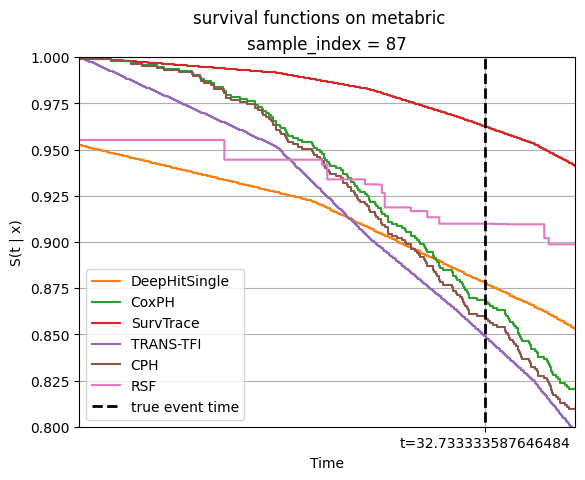

In [14]:
#sample_index = random.randint(0, 100)
sample_index = 87
surv_results = {} # for later usage
cox_risk_scores = {}  # for later usage
et_train_test = {} # for later usage

for i, model_name in enumerate(model_list):
    if model_name in BASELINES:
        surv_full, surv, durations_test, et_train, et_test = infer_surv_of_baselines(model_name, dataset, time_range, group=group, experiment_root=experiment_root)
    if model_name in TRANSFORMERS:
        surv_full, surv, durations_test, et_train, et_test = infer_surv_of_transformers(model_name, dataset, group=group, experiment_root=experiment_root)
    if model_name in COX_SPIRIT_MODELS:
        surv_full, surv, risk_scores, durations_test, et_train, et_test = infer_surv_of_cox_spirit_models(model_name, dataset, group, experiment_root=experiment_root)
        cox_risk_scores[model_name] = risk_scores

    plt.step(surv.index, surv.iloc[:, sample_index], where="post", color=f"C{i+1}", label=model_name)
    
    surv_results[model_name] = surv_full
    et_train_test[model_name] = (et_train, et_test)
    
plt.vlines(durations_test[sample_index], 0, 1, color='k', linestyles='--', linewidth=2, label='true event time')    
plt.xticks([durations_test[sample_index]], labels=[f't={durations_test[sample_index]}'])
plt.suptitle(f"survival functions on {dataset}")
plt.title(f"sample_index = {sample_index}")
plt.ylabel('S(t | x)')
plt.xlabel('Time')
plt.ylim(0.8, 1.0)
plt.xlim(0, 40)
plt.legend(loc='lower left')
plt.grid(True)

## Time-dependent AUROC
- We predict the occurrence of an event in a period up to time `t` dynamically using `cumulative_dynamic_auc()` provided by scikit-survival package

* Why do this?
    > At enrollment a subject is usually healthy, but may be diseased at some later time point. Consequently, sensitivity and specificity become time-dependent measures.

In [11]:
if dataset == 'dialysis':
    va_times = [365 * 1, 365 * 3, 365 * 5, 365 * 7] # evaluate at 1yr, 3yr, 5yr, 7yr
    horizons = [ f"{i}yr" for i in [1,3,5,7] ]
else:
    va_times = STConfig['duration_index'][1:-1] # the discrete intervals are cut at 5%, 10%, 15%, ..., 95%
    horizons = STConfig['horizons']
    
print(f"va_times: {va_times}, \n horizons: {horizons}")

va_times: [365, 1095, 1825, 2555], 
 horizons: ['1yr', '3yr', '5yr', '7yr']


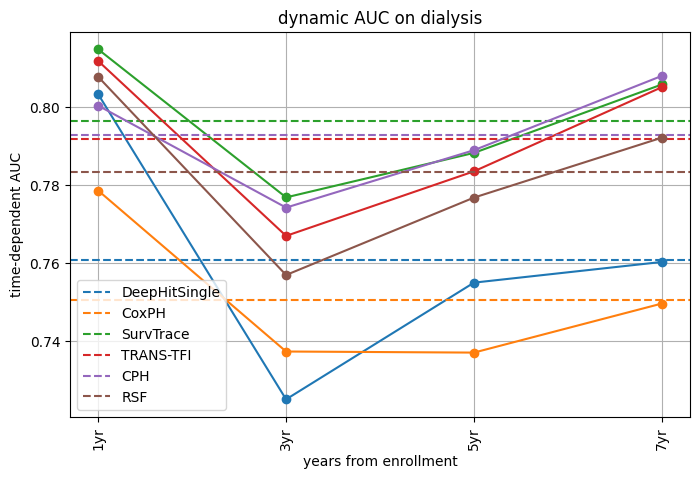

In [12]:
plt.figure(figsize=(8,5))
for i, model_name in enumerate(model_list):
    if model_name in COX_SPIRIT_MODELS:
        out_risk = cox_risk_scores[model_name]
        dynamic_aucs = []
        for j in range(len(va_times)):
            dynamic_aucs.append(
                cumulative_dynamic_auc(et_train, et_test, out_risk, va_times[j])[0].item()
            )
    else:
        surv = surv_results[model_name]
        (et_train, et_test) = et_train_test[model_name]

        # select idx at times
        idx = idx_at_times(surv.index, va_times, 'post')
        out_survival = surv.iloc[idx].T
        out_risk = 1.0 - out_survival

        # pd -> numpy
        out_risk = np.array(out_risk)
    
        dynamic_aucs = []
        for j in range(len(va_times)):
            dynamic_aucs.append(
                cumulative_dynamic_auc(et_train, et_test, out_risk[:, j], va_times[j])[0].item()
            )
        
    plt.plot(va_times, dynamic_aucs, color=f'C{i}', marker='o')
    plt.axhline(np.mean(dynamic_aucs), color=f'C{i}', linestyle='--', label=model_name)

plt.title(f"dynamic AUC on {dataset}")
plt.xticks(va_times, horizons, rotation=90)
if dataset != 'dialysis':
    plt.xlabel("days from enrollment (percentile)")
else:
    plt.xlabel("years from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend()
plt.grid(True)